# Chain using langGraph

How to use chat messages as our graph state
How to use chat models in graphs models
How to bind tools to our LLM in chat models
How to execute the tools call in our graph nodes

In [87]:
import os
from dotenv import load_dotenv
load_dotenv()
load_dotenv(dotenv_path="C:/Users/hp/Documents/GenAI/.env.txt")

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")  


In [88]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages=[AIMessage(content="Please tell me how can I help", name="LLMmodel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Etienne"))
#messages.append(AIMessage(content=f"which programming language you want to learn",name="LLMmodel"))


for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMmodel

Please tell me how can I help
================================ Human Message =================================
Name: Etienne

I want to learn coding


In [90]:
#Chat Models
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.3-70b-versatile")
result=llm.invoke(messages)
result.content


'Learning to code can be a rewarding and challenging experience. Here are some steps to help you get started:\n\n1. **Choose a programming language**: With so many languages out there, it can be hard to decide which one to learn first. Some popular choices for beginners include:\n\t* Python: Known for its simplicity and versatility.\n\t* JavaScript: Used for web development, game development, and mobile app development.\n\t* HTML/CSS: Not a programming language, but essential for building websites and web applications.\n2. **Get the right resources**:\n\t* Online courses: Websites like Codecademy, Coursera, and Udemy offer interactive coding lessons.\n\t* Books: "Code Complete" by Steve McConnell, "Clean Code" by Robert C. Martin, and "Introduction to Algorithms" by Thomas H. Cormen are highly recommended.\n\t* Communities: Join online forums like GitHub, Stack Overflow, or Reddit\'s r/learnprogramming to connect with other coders.\n3. **Set up a coding environment**:\n\t* Choose a tex

In [91]:
result.response_metadata

{'token_usage': {'completion_tokens': 482,
  'prompt_tokens': 52,
  'total_tokens': 534,
  'completion_time': 0.90839827,
  'prompt_time': 0.011719238,
  'queue_time': 0.194789649,
  'total_time': 0.920117508},
 'model_name': 'llama-3.3-70b-versatile',
 'system_fingerprint': 'fp_6507bcfb6f',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

In [92]:
## Tools

def add(a:int,b:int)->int:
    """ Add a and b
Args:
    a(int):first int
    b(int):second int
Returns:
    int
    """
    return a+b
add(1,1)

2

In [93]:
###  Binding llm with tools

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content="what is 2+ 2", name="Etienne")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5tn6kxvps', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 267, 'total_tokens': 282, 'completion_time': 0.031513241, 'prompt_time': 0.033601635, 'queue_time': 0.195463297, 'total_time': 0.065114876}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c151b6a0-cba8-43a6-a0a4-f021eb2077d8-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': '5tn6kxvps', 'type': 'tool_call'}], usage_metadata={'input_tokens': 267, 'output_tokens': 15, 'total_tokens': 282})

In [94]:
##Using messages as state

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

#class state(TypedDict):
#    message:list[AnyMessage]

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    name:str


In [95]:
## Reducers with add_messages
initial_messages=[AIMessage(content="Please tell me how can I help", name="LLMmodel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Etienne"))

ai_message=AIMessage(content=f"which programming language you want to learn",name="LLMmodel")

In [96]:
# APPEND IT INSTEAD TO OVERWRITE
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMmodel', id='d556478c-d264-47ae-8e28-367df854c68f'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Etienne', id='594f024c-071b-4582-b8e1-d4a4a0076f30'),
 AIMessage(content='which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMmodel', id='dfceda0f-10d4-4d94-8d42-00fe9477496e')]

In [97]:
def llm_tool(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}


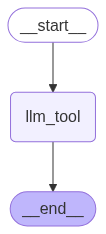

In [98]:
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END

builder = StateGraph(State)
builder.add_node("llm_tool", llm_tool)


builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)


graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
messages=graph.invoke({'messages':"what is the result of 2+2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is the result of 2+2
================================== Ai Message ==================================

<function=add{"a":2,"b":2}</function>


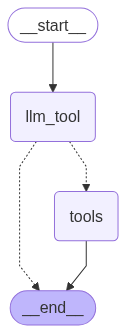

In [100]:
from langgraph.prebuilt import ToolNode, tools_condition

tools=[add]
builder = StateGraph(State)
builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools))

# Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool",
    tools_condition)
    

builder.add_edge("tools",END)


graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [101]:
messages=graph.invoke({'messages':"what is the result of 2+2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is the result of 2+2
================================== Ai Message ==================================
Tool Calls:
  add (jnws8x1yg)
 Call ID: jnws8x1yg
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [103]:
messages=graph.invoke({'messages':"what is machine learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is machine learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to perform a specific task without being explicitly programmed. It allows systems to learn from data, identify patterns, and make predictions or decisions with minimal human intervention.

Machine learning involves training a model on a dataset, which enables the model to learn from the data and improve its performance on a specific task. The goal of machine learning is to develop models that can generalize well to new, unseen data, and make accurate predictions or decisions.

There are several types of machine learning, including:

1. **Supervised learning**: The model is trained on labeled data, where the correct output is already known. The model learns to map 